## 1. Densely Connected Networks
Following my previous article on Convolutional Neural Networks this time i’ll be writing about another form of image classification which is Densely Connected Networks or in short DenseNet.

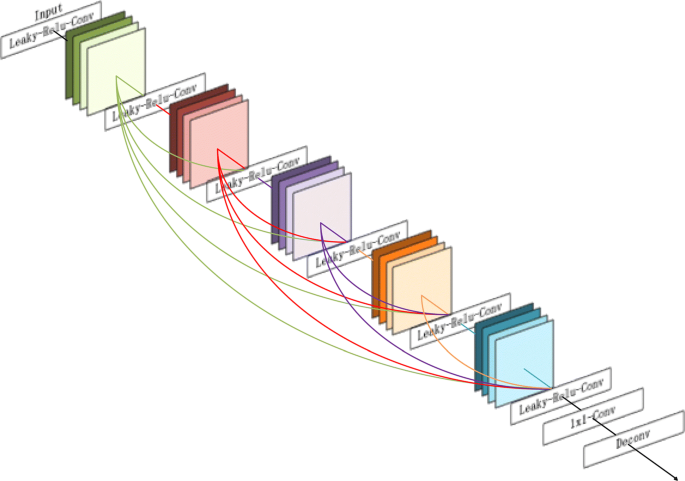

The most basic neural network architecture in deep learning is a dense neural network composed of dense layers (also known as fully connected layers). In this layer, all inputs and outputs are connected to all neurons in each layer. DenseNet is a short for “Densely Connected Convolutional Networks”. The latest version now supports a more efficient DenseNet-Bottleneck-Compressed network. By using DenseNet-BC-190–40 model one can get the most advanced performance on CIFAR-10 and CIFAR-100 datasets. Its architecture can be schematically depicted as seen on above image.


## 2. Architecture
DenseNet is an extension to Wide Residual Networks (or ResNet). DenseNet got its name because the dependency graph between variables has become very dense. The last layer of such a chain is tightly connected to all previous layers. Dense connection is shown in Figure below.

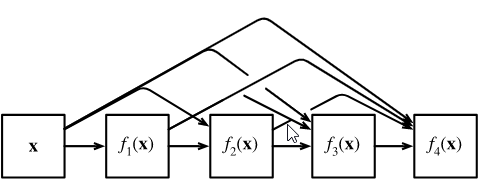

The main components of DenseNet are “dense blocks” and “transition layers”. The former defines the connection mode of inputs and outputs, while the latter controls the number of channels so as not to be too large.

It has some improvements, such as:
1. Dense connectivity: Connect any layer to any other layer.
2. The growth rate parameter indicates the speed at which the number of features increases as the network becomes deeper.
3. Continuous function: BatchNorm-Relu-Conv, from the Wide ResNet paper, from the improvement of the ResNet paper.

Bottlenecks-Compressed DenseNets provide more performance advantages, such as reducing the number of parameters with similar or better performance.
1. Consider the DenseNet-100–12 model (with nearly 7 million parameters), while the DenseNet-BC-100–12 model has only 800,000 parameters. Compared with the 4.10%
2. error of the original model, the BC model achieves an error of 4.51% The best original model DenseNet-100–24 (27.2 million parameters) achieves an error of 3.74%, while DenseNet-BC-190–40 (25.6 million parameters) achieves The 3.46% error is the latest technology level of CIFAR-10.

## 3. Dense Blocks

DenseNet uses ResNet’s modified “batch normalization, activation and convolution”. One can implement this convolution block structure as follows

```
from d2l import tensorflow as d2l
import tensorflow as tf

class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same')

        self.listLayers = [self.bn, self.relu, self.conv]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        y = tf.keras.layers.concatenate([x,y], axis=-1)
        return y
```
The dense block is composed of multiple convolutional blocks, and each convolutional block uses the same number of output channels. However, in forward propagation, we concatenate the input and output of each convolution block on the channel dimension:

```
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x
```
In the example below, we define a DenseBlock instance, which has 2 convolutional blocks, and each convolutional block has 10 output channels. When using an input with 3 channels, we will get an output of 3 + 2×10 = 23 channels. The growth rate can be defined as the number of channels in the convolution block, controls the growth in the number of output channels relative to the number of input channels.

## 4. Transition Layers
Since each dense block increases the number of channels, adding too many channels will make the model too complex. The transition layer is used to control the complexity of the model. It reduces the number of channels by using a 1×1 convolutional layer, and halves the height and width of the average pooling layer with a step size of 2, which further reduces the complexity of the model.

```
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        return self.avg_pool(x)
```

## 5. Build a DenseNet Model using Keras
After setting up the python environment, you should be able to import the keras package:

In [1]:
import keras
keras.__version__

'2.4.3'

## 6. Preparing the Data
First one needs to load the dataset from the MNIST library:

In [2]:
from keras.datasets import mnist

# obtenemos los datos para train y test 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print(x_train.ndim) 

3


In [4]:
print(x_train.shape)

(60000, 28, 28)


In [5]:
print(x_train.dtype)

uint8


In [6]:
len (y_train)

60000

to see one of the images on the dataset just loaded you can use matplotlib as follows and plot its contents as can be seen on the image below:


1


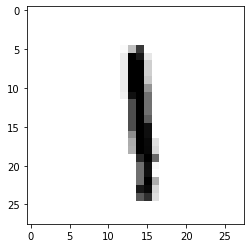

In [7]:
import matplotlib.pyplot as plt
plt.imshow(x_train[8], cmap=plt.cm.binary)
print(y_train[8])

to view the matrix values of the same element selected previously one can use numpy as stated bellow and the result output is on image below the code

In [8]:
import numpy
from numpy import linalg
numpy.set_printoptions(precision=2, suppress=True, linewidth=120)
print(numpy.matrix(x_train[8]))



[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   5  63 197   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  20 254 230  24   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  20 254 254  48   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  20 254 255  48   0   0   0   

4


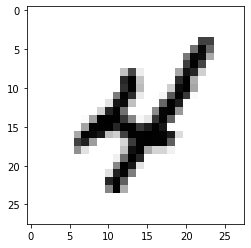

In [9]:
plt.imshow(x_train[9], cmap=plt.cm.binary)
print(y_train[9])

3


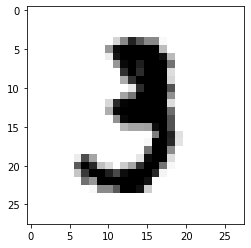

In [10]:
plt.imshow(x_train[10], cmap=plt.cm.binary)
print(y_train[10])

6


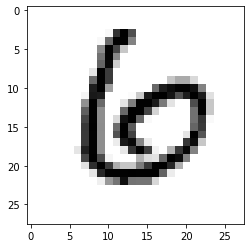

In [11]:
plt.imshow(x_test[11], cmap=plt.cm.binary)
print(y_test[11])

We also need to normalize the image pixel values ​​on the dataset from [0,255] to [0,1] to make our network easier to train (smaller centering values ​​usually lead to better results). Since Keras requires three-dimensional dimensions, we also adjust the shape of each image from (28, 28) to (28, 28, 1).

In [12]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255


In [13]:
print(numpy.matrix(x_train[8]))

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.25 0.77 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.08 1.   0.9  0.09 0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]

In [14]:

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)


print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [15]:
print(y_test[0])

7


In [16]:
print(y_train[0])

5


In [17]:
print(y_train.shape)

(60000,)


In [18]:
print(x_test.shape)

(10000, 784)


encoding labels to categorical data, i.e., simply converting each value in a column to a number as follows :

In [19]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [20]:
print(y_test[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [21]:
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [22]:
print(y_train.shape)

(60000, 10)


In [23]:
print(y_test.shape)

(10000, 10)


## 7. Building the Model
Each Keras model is either built using Sequential classes that represent a linear layer stack, or built using customizable functional Model classes. We will use a simpler sequential model because our CNN will be a linear layer stack.
We start by instantiating a Sequential model:

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(10, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________



## 8. Compiling and fitting the Model
Before starting the training, we need to configure the training process. We have identified 3 key factors in the compilation step:
* The optimizer. We will keep a very good default value: an optimizer based on Adam gradient. Keras also provides many other optimizers.
* The loss function. Since we are using the Softmax output layer, we will use cross entropy loss. Keras distinguishes binary_crossentropy (2 classes) and categorical_crossentropy (> 2 classes), so we will use the latter. See all Keras losses.
* A list of metrics. Since this is a classification problem, we only need Keras to report accuracy metrics.

Next, you need to specify some parameters, and then start the model fitting. There are many possible parameters, but we will only provide these parameters:
* The training data (images and labels), commonly known as X and Y, respectively.
* The number of epochs (iterations over the entire dataset) to train for.
* The batch size (number of samples processed before the model is updated)

Calling model.fit()performs the analysis of the given input, then calculates the indicator function specified in model.compile() based on train_images and train_labels, and returns the calculated indicator value as output.

We must pay attention to one thing: Keras expects the training target to be a 10-dimensional vector, because there are 10 nodes in our hidden layers.

The compilation looks like this:


In [25]:
batch_size = 50
num_classes = 10
epochs=10

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1
          )


Epoch 1/10
1200/1200 [==============================] - 1s 1ms/step - loss: 2.0782 - accuracy: 0.4062
Epoch 2/10
1200/1200 [==============================] - 1s 1ms/step - loss: 1.6672 - accuracy: 0.6637
Epoch 3/10
1200/1200 [==============================] - 1s 1ms/step - loss: 1.3254 - accuracy: 0.7399
Epoch 4/10
1200/1200 [==============================] - 1s 1ms/step - loss: 1.0804 - accuracy: 0.7790
Epoch 5/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.9147 - accuracy: 0.8075
Epoch 6/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.7993 - accuracy: 0.8297
Epoch 7/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.7159 - accuracy: 0.8437
Epoch 8/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.6536 - accuracy: 0.8546
Epoch 9/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.6057 - accuracy: 0.8614
Epoch 10/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.567

## 9. Evaluating the Model
Evaluating a model from Keras actually only involves calling the fucntionevaluate(). The model.evaluate function
* The validation data (or test data), which is used during training to periodically measure the performance of the network based on data that has never been seen before

The evaluation results are retrieved form the variables assigned to the function evaluate().

In [26]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 0s 858us/step - loss: 0.5391 - accuracy: 0.8737
Test loss: 0.5390798449516296
Test accuracy: 0.8737000226974487


## 10. Predicting the Model

Predicting a model from Keras actually only involves calling the functionmodel.predict().
* The validation data (or test data), which is used during training to periodically measure the performance of the network based on data that has never been seen before

The prediction results are retrieved from the dataset assigned to the function predict().

In [27]:
predictions = model.predict(x_test)

Remember the result data is encoded to categorial data and this means each element position on the vector represents the integer value at test. For instance, to view the predictions results for the 10th element in the dataset :

In [28]:
print(predictions[10])

[0.78 0.   0.04 0.04 0.   0.07 0.   0.01 0.05 0.  ]


The predicted element with the higher probability, in the categorical dataset, corresponds to the predicted number, for the same 11th element, can be calculated as follows :

In [29]:
numpy.sum(predictions[10])

1.0

To view the predicted value (number) one can call the argmax value or “maximum arguments”, the index of the maximum value of each element in the list:

In [30]:
numpy.argmax(predictions[10])

0

## 11. View the Confusion Matrix
The code below is taken directly from the SKLEARN website, which is a good way to view the confusion matrix. The function presented below prints and plots the confusion matrix. Normalization can be applied by setting “normalize = True”.

In [31]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')



Next, is needed to “one hot encode” the categorical data so i can be easily understandable. One hot encoding is a way of represent categorical variables as binary vectors. This requires mapping the classification values to integer values. Then, each integer value is represented as a binary vector, which has all zero values ​​except for the integer index (the index marked with 1).

In [32]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = numpy.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = numpy.argmax(y_test, axis = 1) 


and finally compute and plot the confusion matrix in a nice and readable graph chart type as follows :

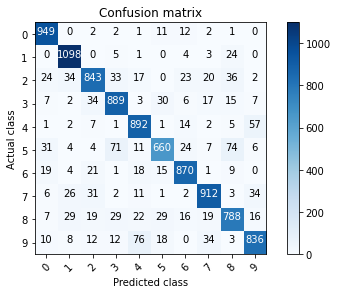

In [33]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

## 12. References
[1] Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4700–4708).